In [1]:
import torch
import os
import rasterio
import yaml
from train import create_dataloader
import numpy as np
import matplotlib.pyplot as plt
from model import CustomResNet
from torch.nn.functional import softmax
import pandas as pd
import warnings
warnings.filterwarnings("ignore",category=UserWarning,module='rasterio')


INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


## Load model
Load in a trained model and set it up to evaluate. Step-by-step:
- Read the configuration file
- Create a dataloader from training and validation data cause we want to see performance.
- Creae an instance of the model using the base architecture
- Load trained weights into model instance

In [13]:
# Load cfgs and dataset:
cfg = yaml.safe_load(open('/home/Mariam/codes/ct_classifier/configs/exp_resnet18.yaml', 'r'))
dl_train = create_dataloader(cfg, split='train',eval=True)
dl_val = create_dataloader(cfg, split='val', eval=True)
#create model instance
model_instance = CustomResNet(cfg['num_classes'], cfg['layers']) 
# load a pretrained checkpoint
checkpoint_path = '/home/Mariam/codes/ct_classifier/model_states/100.pt'
state = torch.load(open(checkpoint_path, 'rb'), map_location='cpu')
model_instance.load_state_dict(state['model'])
model_instance.eval()

/home/Mariam/miniconda3/envs/cv4ecology/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/Mariam/miniconda3/envs/cv4ecology/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_654427/382336120.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pyt

CustomResNet(
  (feature_extractor): ResNet(
    (conv1): Conv2d(16, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

## Get model predictcions
Define a function to run the model and save all outputs into a dataframe.

In [14]:
def get_model_preds(dataloader,model,device='cpu'):
    all_labels = []
    all_preds = []
    all_softmax = []
    all_image_id1 = []
    all_image_id2 = []
    model.eval()
    model.to(device)
    for idx, (data, labels,image_couples) in enumerate(dataloader):   
        image_idx1, image_idx2 =  image_couples
        data=data.to(device)
        with torch.no_grad():
            predictions = model(data).to('cpu')
        softmax_scores = softmax(predictions,dim=1)
        all_labels.append(labels)
        all_preds.append(predictions)
        all_softmax.append(softmax_scores)
        all_image_id1.append(image_idx1)
        all_image_id2.append(image_idx2)
    all_labels = np.concatenate(all_labels)
    str_labels = ['bleached' if l==1 else 'healthy' for l in all_labels]
    #print(np.concatenate(all_image_id1).shape,np.concatenate(all_image_id2).shape,np.concatenate(all_softmax).shape, )
    df = pd.DataFrame({'image_id1':np.concatenate(all_image_id1),'image_id2':np.concatenate(all_image_id2), 'softmax_bleach_scores':np.concatenate(all_softmax)[:,1],
                         'raw_bleach_scores':np.concatenate(all_preds)[:,1],'labels': all_labels, 'str_labels':str_labels} )
    df['image_path1'] = df.image_id1.map(lambda idx: dataloader.dataset.meta.query('image_id==@idx').filepath.values[0]) # get image paths
    df['image_path2'] = df.image_id2.map(lambda idx: dataloader.dataset.meta.query('image_id==@idx').filepath.values[0])
    df['site'] = df.image_id1.map(lambda idx: dataloader.dataset.meta.query('image_id==@idx').site.values[0])
    df['filename']= df.image_id1.map(lambda idx: dataloader.dataset.meta.query('image_id==@idx').filename.values[0])
    return df

In [15]:
train_scores_df = get_model_preds(dl_train,model_instance)

In [16]:
train_scores_df

,image_id1,image_id2,softmax_bleach_scores,raw_bleach_scores,labels,str_labels,image_path1,image_path2,site,filename
0,126,134,0.996884,3.120612,1.0,bleached,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,sanagustin_mexico,loc001.tif
1,161,162,0.023283,-1.596745,0.0,healthy,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,northpoint_lizard,loc001.tif
2,162,154,0.002945,-2.852097,0.0,healthy,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,northpoint_lizard,loc001.tif
3,154,177,0.991665,2.437683,1.0,bleached,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,northpoint_lizard,loc001.tif
4,154,173,0.996190,2.989060,1.0,bleached,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,northpoint_lizard,loc001.tif
...,...,...,...,...,...,...,...,...,...,...
1050,17,83,0.991409,2.572419,1.0,bleached,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,cheeca_flkeys,loc001.tif
1051,26,20,0.183782,-0.761671,0.0,healthy,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,cheeca_flkeys,loc003.tif
1052,161,168,0.969268,1.691901,1.0,bleached,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,northpoint_lizard,loc001.tif
1053,26,38,0.052637,-1.164430,0.0,healthy,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,cheeca_flkeys,loc003.tif


In [17]:
train_scores_df = get_model_preds(dl_train,model_instance,device='cuda')
val_scores_df = get_model_preds(dl_val,model_instance,device='cuda')

str_labels
bleached    Axes(0.125,0.11;0.775x0.77)
healthy     Axes(0.125,0.11;0.775x0.77)
Name: raw_bleach_scores, dtype: object

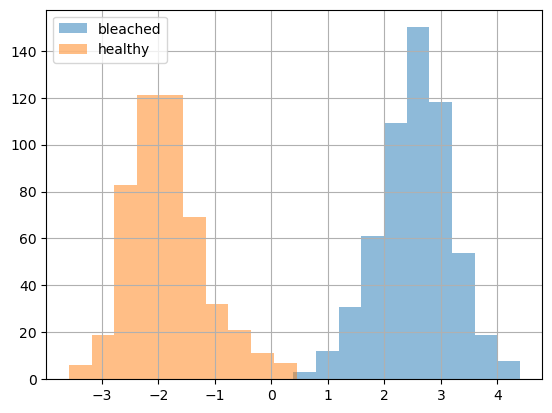

In [18]:
train_scores_df.groupby('str_labels').raw_bleach_scores.hist(alpha=0.5,legend=True)

str_labels
bleached    Axes(0.125,0.11;0.775x0.77)
healthy     Axes(0.125,0.11;0.775x0.77)
Name: softmax_bleach_scores, dtype: object

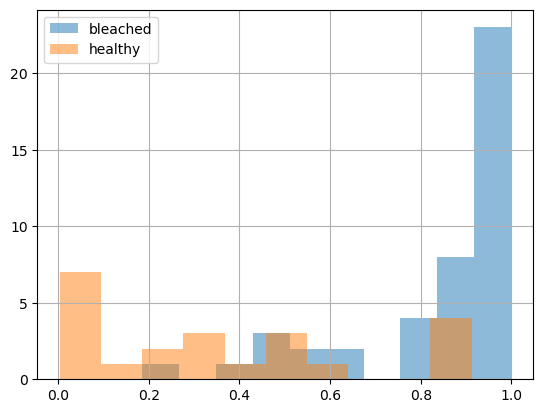

In [19]:
val_scores_df.groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True)

str_labels
bleached    Axes(0.125,0.11;0.775x0.77)
healthy     Axes(0.125,0.11;0.775x0.77)
Name: softmax_bleach_scores, dtype: object

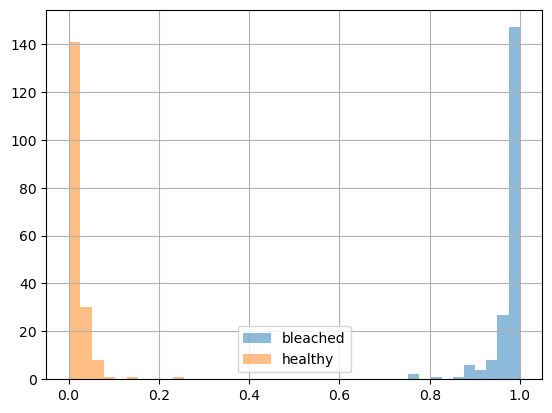

In [20]:
train_scores_df[train_scores_df['site']=='northpoint_lizard'].groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True)

/tmp/ipykernel_654427/46010813.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_scores_df[train_scores_df['site']=='northpoint_lizard'].groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True)


str_labels
bleached    Axes(0.125,0.11;0.775x0.77)
healthy     Axes(0.125,0.11;0.775x0.77)
Name: softmax_bleach_scores, dtype: object

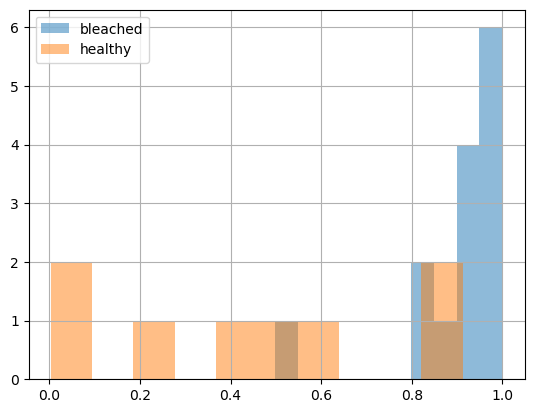

In [22]:
val_scores_df[train_scores_df['site']=='northpoint_lizard'].groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True)

/tmp/ipykernel_654427/723991489.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_scores_df[train_scores_df['site']=='sanagustin_mexico'].groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True)


str_labels
bleached    Axes(0.125,0.11;0.775x0.77)
healthy     Axes(0.125,0.11;0.775x0.77)
Name: softmax_bleach_scores, dtype: object

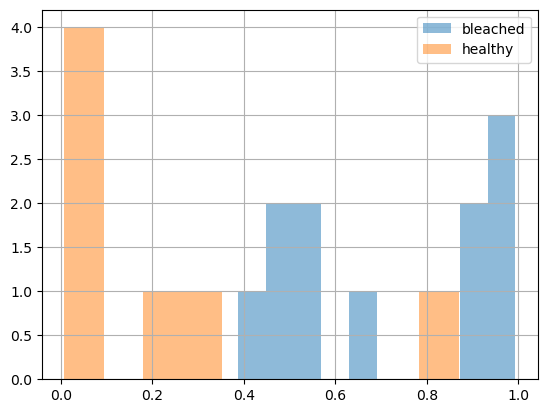

In [30]:
val_scores_df[train_scores_df['site']=='sanagustin_mexico'].groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True)

In [29]:
val_scores_df[train_scores_df['site']=='lbcaye_bbr'].groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True)

/tmp/ipykernel_654427/1483969283.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_scores_df[train_scores_df['site']=='lbcaye_bbr'].groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True)


Series([], Name: softmax_bleach_scores, dtype: float32)